# Multclassification 

In [12]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.preprocessing.image import array_to_img
import os

data_dir = '/work/users/n/s/nsivaku/datasets/562proj'
folder_path = f'{data_dir}/562Data V2 - Values.csv'
df = pd.read_csv(folder_path)

thumbnails_dir = f'{data_dir}/thumbnails-jpegs-v2'

cats = df['Category'].nunique()
print(cats)

# defines quartiles for each unique category
quartiles = df.groupby('Category')['View Count'].quantile([0.25, 0.5, 0.75]).unstack()

def assign_quartile(category, view_count):
    Q1 = quartiles.loc[category, 0.25]
    Q2 = quartiles.loc[category, 0.5]
    Q3 = quartiles.loc[category, 0.75]
    
    if view_count <= Q1:
        return 1
    elif view_count <= Q2:
        return 2
    elif view_count <= Q3:
        return 3
    else:
        return 4
 
X = []
y = []
titles = []
categories = []

    
for img in os.listdir(thumbnails_dir):
    img_path = os.path.join(thumbnails_dir, img)
    loc = df.loc[df['Id'] == img[:-4]] ## locates the matching ids for images and corresponding feature in csv
    if loc.empty:                      ## as some of our data has no matching ids, just skip and remove the data
        os.remove(img_path)
        
    else:
        if np.float32(np.asarray(loc['View Count'])[0]) > 0:
            thumb = load_img(img_path)
            thumb_256 = thumb.resize((256,256))         ## resize all images to 256 x 256, easier to work with in Conv2d
            X.append(np.asarray(thumb_256))             ## append all images as arrays to X
            category = loc['Category'].iloc[0]           ## Extract single value from Series
            categories.append(category)  # append category
            titles.append(loc['Title'].iloc[0])  # append title
            y.append(assign_quartile(category, np.float32(np.asarray(loc['View Count'])[0])))  ## compute quartile & save
assert(len(y) == len(X))


19


Entertainment,Comedy
Honest Trailers - The Avengers
VideoGames
3D Gaming - Scott The Woz
VideoGames
Mess Effect
VideoGames
AK47 Tutorial CS:GO


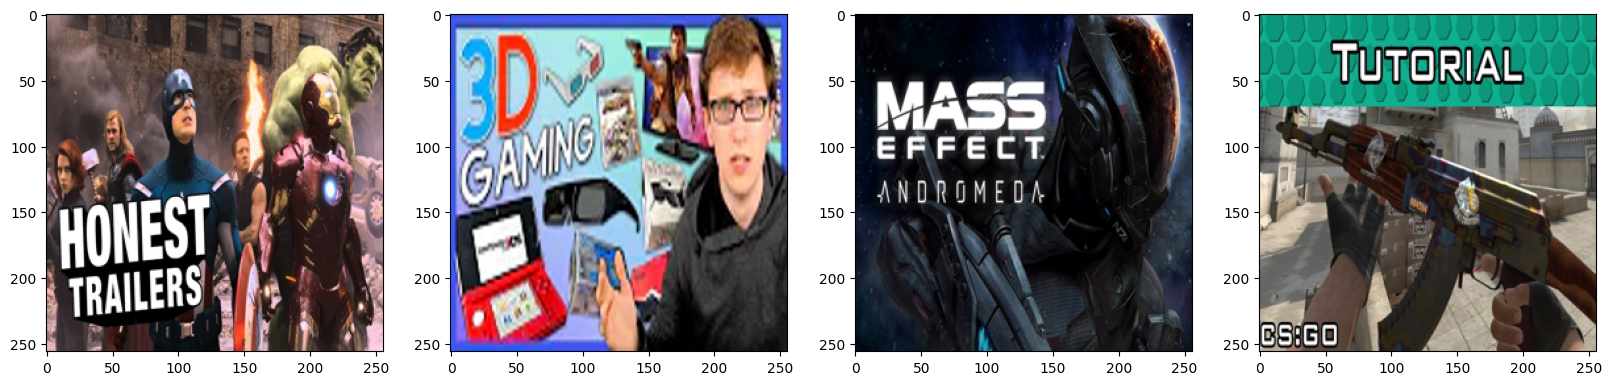

In [2]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
#print 4 thumbnails to verify not totally broken 
for i in range(4):
    ax[i].imshow(X[i+1310].astype(int))
    print(categories[i+1310])
    print(titles[i+1310])

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Text Tokenization and Padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(titles)
title_sequences = tokenizer.texts_to_sequences(titles)
title_sequences_padded = pad_sequences(title_sequences, maxlen=50, padding='post', truncating='post')

# One-hot encoding
categories_one_hot = pd.get_dummies(categories)
categories_one_hot_array = categories_one_hot.values

print(len(titles))

#Cast to array 
X_array = np.array(X)

# Create TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices((
    {'image_input': X_array, 'category_input': categories_one_hot_array, 'title_input': title_sequences_padded},
    y
))

# Define batch size
batch_size = 32
dataset = dataset.batch(batch_size)


# normalize features
dataset = dataset.map(lambda features, label: (tf.cast(features['image_input']/255, tf.float32), 
                                               features['category_input'],
                                               features['title_input'], 
                                               label))

3144


2024-04-26 22:27:14.848893: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
train_size = int(len(dataset) * 0.7)
val_size = int(len(dataset) * 0.2)
test_size = int(len(dataset) * 0.1)

print(len(dataset))
print("Train Size:", train_size)
print("Validation Size:", val_size)
print("Test Size:", test_size)

# Shuffle the dataset
dataset_shuffled = dataset.shuffle(len(dataset), seed=42)

# Split the dataset
train_dataset = dataset_shuffled.take(train_size)
val_dataset = dataset_shuffled.skip(train_size).take(val_size)
test_dataset = dataset_shuffled.skip(train_size + val_size).take(test_size)

# Shuffle each set separately
train_dataset = train_dataset.shuffle(buffer_size=train_size, seed=42)
val_dataset = val_dataset.shuffle(buffer_size=val_size, seed=42)
test_dataset = test_dataset.shuffle(buffer_size=test_size, seed=42)

99
Train Size: 69
Validation Size: 19
Test Size: 9


In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input, concatenate, Embedding, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD

# Define the model
image_input = Input(shape=(256, 256, 3), name='image_input')
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(image_input)
maxpool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(maxpool1)
maxpool2 = MaxPooling2D((2, 2))(conv2)
flatten_img = Flatten()(maxpool2)

# Process category input with one layer
category_input = Input(shape=(categories_one_hot_array.shape[1],), name='category_input')
category_dense = Dense(32, activation='relu')(category_input)

# Process title input with one layer
title_input = Input(shape=(title_sequences_padded.shape[1],), name='title_input')
title_embedding = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50)(title_input)
title_flatten = Flatten()(title_embedding)
title_dense = Dense(32, activation='relu')(title_flatten)

# Merge all inputs
merged = concatenate([flatten_img, category_dense, title_dense])

dense1 = Dense(128, activation='relu')(merged)
batch_norm1 = BatchNormalization()(dense1)
dropout1 = Dropout(0.3)(batch_norm1)

dense2 = Dense(64, activation='relu')(dropout1)
batch_norm2 = BatchNormalization()(dense2)
dropout2 = Dropout(0.3)(batch_norm2)

num_output_neurons = cats # 19 cats 

# Output layer for regression
output = Dense(num_output_neurons, activation='softmax')(dropout2)  # num_output_neurons should be calculated based on your data

# Create model
model = Model(inputs=[image_input, category_input, title_input], outputs=output)

initial_lr = 0.001
sgd_optimizer = SGD(learning_rate=initial_lr, momentum=0.9)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)


# Compile model
model.compile(optimizer=sgd_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define dataset preparation function, screwt
def prepare_dataset(dataset):
    def prepare_data(image, category, title, label):
        image = tf.ensure_shape(image, (None, 256, 256, 3))
        category = tf.reshape(category, (-1, categories_one_hot_array.shape[1]))
        title = tf.reshape(title, (-1, title_sequences_padded.shape[1]))
        label = tf.one_hot(label, num_output_neurons)  # Update to the correct number of output neurons
        return {'image_input': image, 'category_input': category, 'title_input': title}, label
    return dataset.map(prepare_data)

# Prepare datasets
train_prepared = prepare_dataset(train_dataset)
val_prepared = prepare_dataset(val_dataset)

history = model.fit(
    train_prepared,
    validation_data=val_prepared,
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr]
)

model.summary()


Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 24s 326ms/step - accuracy: 0.0767 - loss: 3.6079 - val_accuracy: 0.0641 - val_loss: 3.8956 - learning_rate: 0.0010
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 23s 336ms/step - accuracy: 0.1949 - loss: 2.9360 - val_accuracy: 0.3503 - val_loss: 2.3415 - learning_rate: 0.0010
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 28s 405ms/step - accuracy: 0.2933 - loss: 2.5197 - val_accuracy: 0.3562 - val_loss: 2.0631 - learning_rate: 0.0010
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 37s 529ms/step - accuracy: 0.4316 - loss: 1.9552 - val_accuracy: 0.5103 - val_loss: 1.6476 - learning_rate: 0.0010
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 39s 570ms/step - accuracy: 0.5353 - loss: 1.5371 - val_accuracy: 0.4359 - val_loss: 1.9012 - learning_rate: 0.0010
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 41s 589ms/step - accuracy: 0.6792 - loss: 1.1140 - val_accuracy: 0.5197 - val_loss: 1.3325 - learning_rate: 0.0010
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 40s 571ms/step - accuracy: 0.7351 - loss: 0.

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 256, 256,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 128, 128,  │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ title_input         │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_10… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, 50, 50)    │    310,200 │ title_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 64, 64,    │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ category_input      │ (None, 19)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_11          │ (None, 2500)      │          0 │ embedding_5[0][0] │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_10          │ (None, 262144)    │          0 │ max_pooling2d_11… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 32)        │        640 │ category_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 32)        │     80,032 │ flatten_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 262208)    │          0 │ flatten_10[0][0], │
│ (Concatenate)       │                   │            │ dense_25[0][0],   │
│                     │                   │            │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 128)       │ 33,562,752 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_27[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 64)        │      8,256 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_28[0][0]  

 Total params: 67,966,168 (259.27 MB)

 Trainable params: 33,982,891 (129.63 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 33,982,893 (129.63 MB)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.9993 - loss: 0.0359
Test Accuracy: 0.9965277910232544


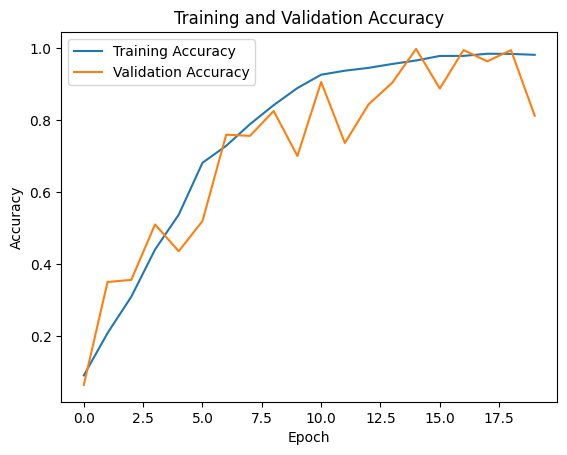

In [11]:
# Evaluate model on test data
test_prepared = prepare_dataset(test_dataset)
loss, accuracy = model.evaluate(test_prepared)
print('Test Accuracy:', accuracy)


# Plot accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


In [17]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get predictions on the test set
test_prepared = prepare_dataset(test_dataset)
test_predictions = model.predict(test_prepared)

# Accumulate true labels from the test dataset
true_classes = []
for features, labels in test_prepared:
    true_classes.extend(np.argmax(labels.numpy(), axis=1))

# Convert predictions to class indices
predicted_classes = np.argmax(test_predictions, axis=1)
print(predicted_classes)
# Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
labels = ['Class {}'.format(i) for i in range(num_output_neurons)]  # Replace with your actual class labels

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'sklearn'